In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Przygotowanie danych

In [12]:
os_errors_df = pd.DataFrame({"Nr miesiąca": [i for i in range(1, 94)],
                                   "Liczba błędów": [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 0, 0, 3, 1, 1, 0, 1, 0, 2, 10, 0, 16, 0, 2, 2, 1, 1, 1, 0, 3, 2, 1, 6, 3, 0, 1, 1, 0, 0, 14, 1, 4, 1, 1, 7, 14, 6, 0, 1, 2, 19, 7, 2, 5, 1, 12, 4, 6, 4, 7, 2, 2, 3, 8, 4, 6, 3, 3, 5, 8, 0, 6, 5, 10, 0, 5, 1, 2, 1, 2, 1, 0]
                                   })

In [13]:
os_errors_df["Sb_t"] = os_errors_df["Liczba błędów"].cumsum()
t = os_errors_df["Nr miesiąca"].values
Sb_t = os_errors_df["Sb_t"].values


In [14]:
os_errors_df

,Nr miesiąca,Liczba błędów,Sb_t
0,1,1,1
1,2,0,1
2,3,0,1
3,4,0,1
4,5,0,1
...,...,...,...
88,89,2,260
89,90,1,261
90,91,2,263
91,92,1,264


# Modelowanie

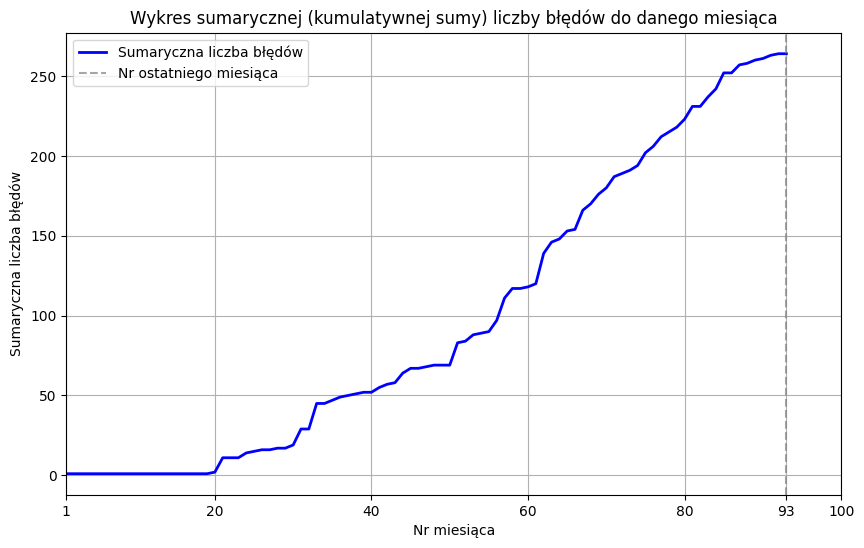

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(t, Sb_t, color='blue', linewidth=2, label='Sumaryczna liczba błędów')
plt.title('Wykres sumarycznej (kumulatywnej sumy) liczby błędów do danego miesiąca')
plt.xlabel('Nr miesiąca')
plt.ylabel('Sumaryczna liczba błędów')
plt.xlim(1, 95)
xticks = plt.xticks()[0].tolist()
xticks = [x for x in xticks if x >= 1]
if 93 not in xticks:
    xticks.append(93)
if 1 not in xticks:
    xticks.append(1)
plt.xticks(xticks)
plt.axvline(93, linestyle='--', color='gray', alpha=0.7, label='Nr ostatniego miesiąca')
plt.legend()
plt.grid(True)
plt.show()

**Obserwacje:** Jak widać po wykresie oraz analizie sumarycznej liczby błędów krytycznych wykazuje charakterystyczny przebieg (S). W początkowej fazie eksploatacji (do ok. 20. miesiąca) przyrost błędów jest bardzo mały, znikomy, co sugeruje fazę wstępnej ekspolatacji systemu. Następnie obserwujemy gwałtowny wzrost dynamiki wykrywania usterek, co sugeruje fazę aktywnego użytkowania oprogramowania. Pod koniec badanego okresu krzywa wyraźnie wykazuje tendencję do nasycenia (wypłaszczania się), co oznacza, że tempo wykrywania nowych błędów spada. Uzasadnione jest zatem użycie modelu logistycznego.

In [16]:
def logistic_function(t, K, a, t0):
  return K / (1 + np.exp(-a * (t - t0)))

def calculate_r_squared(func, y):
  return 1 - (np.sum((y - func) ** 2) / np.sum((y - np.mean(y)) ** 2))

In [17]:
from scipy.optimize import curve_fit

In [18]:
p0 = [max(Sb_t), 1.0, np.median(t)]

popt, pcov = curve_fit(logistic_function, t, Sb_t, p0 = p0)
K_opt, a_opt, t0_opt = popt

print(f"Parametry modelu:\nK (nasycenie) = {K_opt}\na (tempo wzrostu) = {a_opt}\nt0 (punkt przegięcia) = {t0_opt}")

Parametry modelu:
K (nasycenie) = 310.383456079653
a (tempo wzrostu) = 0.06868076775568645
t0 (punkt przegięcia) = 65.73228521859176


In [19]:
print(f"R^2: {calculate_r_squared(logistic_function(t, *popt), Sb_t)}")

R^2: 0.9955850868867113


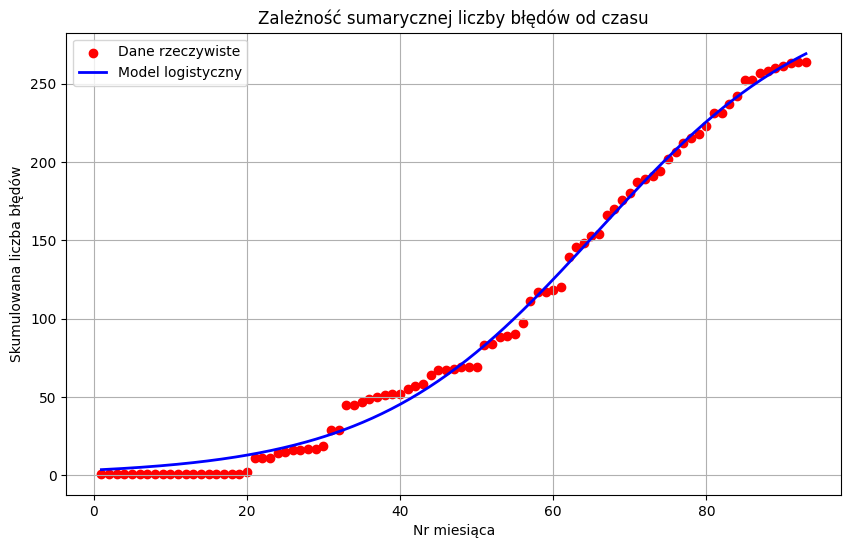

In [20]:
t_smooth = np.linspace(min(t), max(t), 300)
plt.figure(figsize=(10, 6))
plt.scatter(t, Sb_t, color='red', label='Dane rzeczywiste')
plt.plot(t_smooth, logistic_function(t_smooth, *popt), color='blue', linewidth=2, label='Model logistyczny')
plt.title('Zależność sumarycznej liczby błędów od czasu')
plt.xlabel('Nr miesiąca')
plt.ylabel('Skumulowana liczba błędów')
plt.legend()
plt.grid(True)
plt.show()

**Obserwacje:** Nasz model logistyczny bardzo dobrze opisuje proces wykrywania błędów w badanym systemie operacyjnym, świadczy o tym współczynnik determinacji R^2 równy ok. 99,6%. Krzywa praktycznie idealnie pokrywa się z danymi.

Parametr nasycenia K wynosi ok. 310,38. Oznacza to, że teoretyczna, całkowita sumaryczna liczba błędów krytycznych, które mogą wystąpić w okresie eksploatacji SO, wynosi około 310. Biorąc pod uwagę, że w ciągu 93 miesięcy eksploatacji wykryto dotychczas 264 błędy, można wnioskować, że wykryto około 85% wszystkich przewidywanych błędów krytycznych.

Punkt przegięcia t0 wynosi ok. 65,73, co odpowiada końcowi 65. miesiąca eksploatacji SO. Jest to moment w cyklu życia oprogramowania, w którym dynamika przyrostu nowych błędów była największa. Po przekroczeniu tego miesiąca, tempo wykrywania kolejnych błędów krytycznych zaczęło stopniowo maleć, co na wykresie objawia się przejściem krzywej w fazę wypłaszczania

Parametr a wynosi 0,069, co odzwierciedla umiarkowane tempo wzrostu sumarycznej liczby błędów. Ta wartość wskazuje na stabilny i dość długofalowy proces pojawiania się błędów oprogramowania w czasie jego eksploatacji.

Proces pojawiania się błędów w oprogramowaniu badanego systemu operacyjnego przebiega zgodnie z modelem logistycznym (krzywą w kształcie S). Początkowy powolny wzrost, następna faza intensywnego występowania błędów oraz końcowe wygasanie trendu wzrostowego są typowe dla oprogramowania. Choć system zbliża się do fazy nasycenia, parametr K sugeruje, że proces utrzymania powinien być kontynuowany, gdyż system nie osiągnął jeszcze pełnego, teoretycznego poziomu bezawaryjności - nie osiągnął teoretycznej liczby błędów.

https://www.youtube.com/watch?v=pNE1ufDXNSc&t=3s

# Modelowanie dla zagregowanych danych i podziału danych

# Model dla podzielonych dnaych na kwartały

In [21]:
93 / 4

23.25

In [147]:
os_errors_df_quarterly = os_errors_df.copy()
os_errors_df_quarterly["Nr kwartału"] = (os_errors_df["Nr miesiąca"] - 1) // 3 + 1
os_errors_df_quarterly = os_errors_df_quarterly.groupby("Nr kwartału")["Liczba błędów"].sum().reset_index()

# os_errors_df_quarterly
os_errors_df_quarterly["Sb_t_Q"] = os_errors_df_quarterly["Liczba błędów"].cumsum()
# os_errors_df_quarterly.sort_values(by=("Nr kwartału"), axis=1, inplace=True)

print(len(os_errors_df_quarterly))
os_errors_df_quarterly.head()

31


,Nr kwartału,Liczba błędów,Sb_t_Q
0,1,1,1
1,2,0,1
2,3,0,1
3,4,0,1
4,5,0,1


In [148]:
t_Q = os_errors_df_quarterly["Nr kwartału"].values
Sb_t_Q = os_errors_df_quarterly['Sb_t_Q'].values

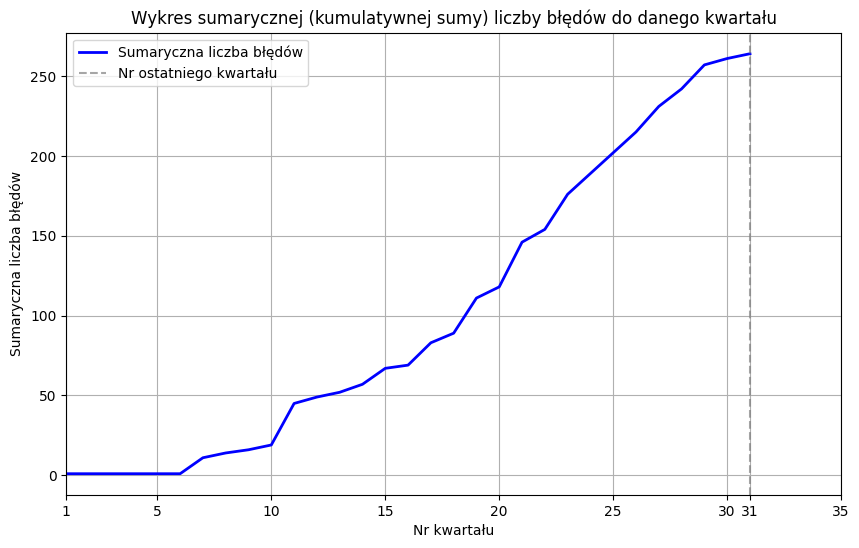

In [149]:
plt.figure(figsize=(10, 6))
plt.plot(t_Q, Sb_t_Q, color='blue', linewidth=2, label='Sumaryczna liczba błędów')
plt.title('Wykres sumarycznej (kumulatywnej sumy) liczby błędów do danego kwartału')
plt.xlabel('Nr kwartału')
plt.ylabel('Sumaryczna liczba błędów')
plt.xlim(1, 32)
xticks = plt.xticks()[0].tolist()
xticks = [x for x in xticks if x >= 1]
if 31 not in xticks:
    xticks.append(31)
if 1 not in xticks:
    xticks.append(1)
plt.xticks(xticks)
plt.axvline(31, linestyle='--', color='gray', alpha=0.7, label='Nr ostatniego kwartału')
plt.legend()
plt.grid(True)
plt.show()

In [150]:
p0 = [max(Sb_t_Q), 1.0, np.median(t_Q)]

popt, pcov = curve_fit(logistic_function, t_Q, Sb_t_Q, p0 = p0)
K_opt, a_opt, t0_opt = popt

print(f"Parametry modelu:\nK (nasycenie) = {K_opt}\na (tempo wzrostu) = {a_opt}\nt0 (punkt przegięcia) = {t0_opt}")

Parametry modelu:
K (nasycenie) = 309.7601019433702
a (tempo wzrostu) = 0.20441685240661894
t0 (punkt przegięcia) = 21.84636132756358


In [151]:
print(f"R^2: {calculate_r_squared(logistic_function(t_Q, *popt), Sb_t_Q)}")

R^2: 0.9956907431816328


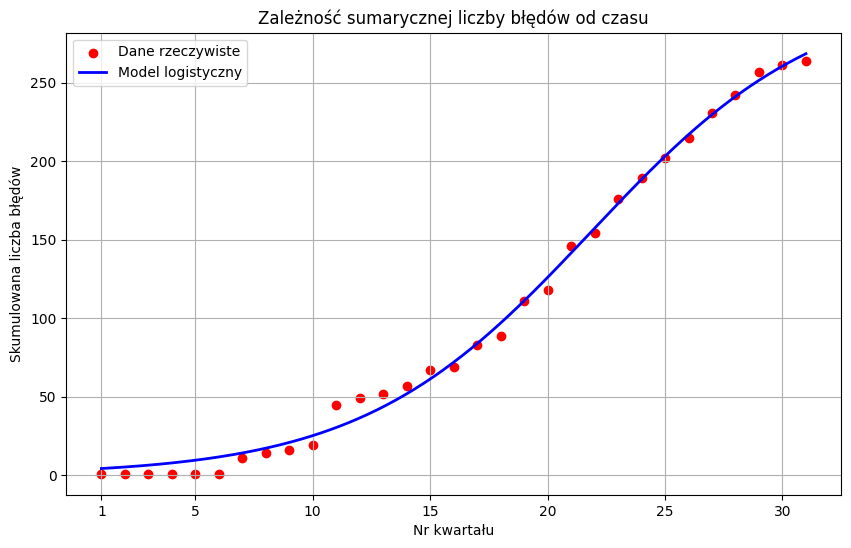

In [152]:
t_smooth_Q = np.linspace(min(t_Q), max(t_Q), 300)
plt.figure(figsize=(10, 6))
plt.scatter(t_Q, Sb_t_Q, color='red', label='Dane rzeczywiste')
plt.plot(t_smooth_Q, logistic_function(t_smooth_Q, *popt), color='blue', linewidth=2, label='Model logistyczny')
xticks = np.arange(0, 35, 5)
xticks = np.append(xticks, 1)
xticks = xticks[xticks != 0]
plt.xticks(xticks)
plt.title('Zależność sumarycznej liczby błędów od czasu')
plt.xlabel('Nr kwartału')
plt.ylabel('Skumulowana liczba błędów')
plt.legend()
plt.grid(True)
plt.show()

# Model dla podzielonych danych (dane treningowe przyjęto jako dane do 60 miesiąca)

In [140]:
# train and test splits lub mozemy przyjac po prostu ze znajdujemy sie (mamy dane do 63. miesiąca a pozostałych nie mamy) w 63. miesiacu
os_errors_train_df = os_errors_df[os_errors_df["Nr miesiąca"] <= 63] # ~68% : ~32% (zazwyczaj sie bierze 70% - 30% lub 80% do 20 % aczkolwiek tutaj te proporcje są zbliżone właśnie do 70% i 30% test setu)
os_errors_test_df = os_errors_df[os_errors_df["Nr miesiąca"] > 63]
os_errors_test_plot_df = os_errors_df[os_errors_df["Nr miesiąca"] >= 63] # po to zeby na wykresie nie było przerwy

In [141]:
t_train, t_test = os_errors_train_df["Nr miesiąca"].values, os_errors_test_df["Nr miesiąca"].values
Sb_t_train, Sb_t_test = os_errors_train_df["Sb_t"].values, os_errors_test_df["Sb_t"].values
t_test_plot, Sb_t_test_plot = os_errors_test_plot_df["Nr miesiąca"].values, os_errors_test_plot_df["Sb_t"].values

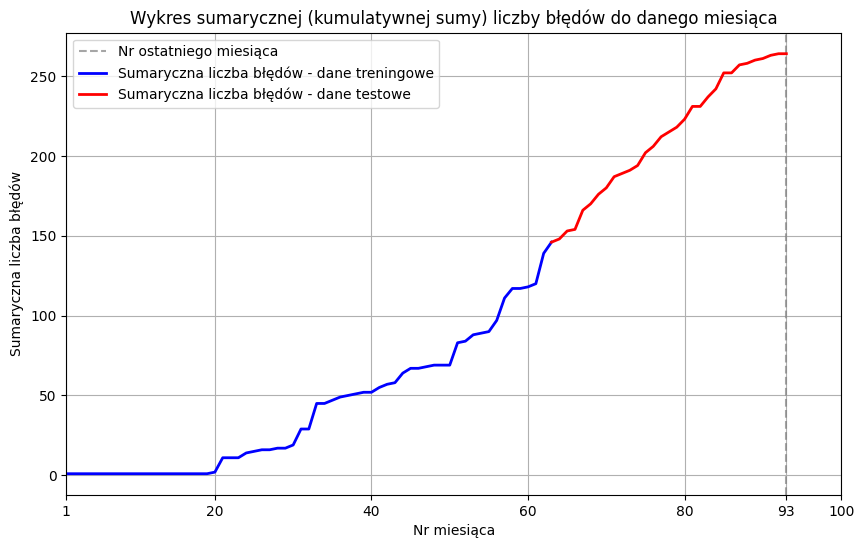

In [142]:
plt.figure(figsize=(10, 6))
plt.title("Wykres sumarycznej (kumulatywnej sumy) liczby błędów do danego miesiąca")
plt.xlabel("Nr miesiąca")
plt.ylabel("Sumaryczna liczba błędów")
plt.xlim(1, 95)
xticks = plt.xticks()[0].tolist()
xticks = [x for x in xticks if x >= 1]
if 93 not in xticks:
    xticks.append(93)
if 1 not in xticks:
    xticks.append(1)
plt.xticks(xticks)
plt.axvline(93, linestyle='--', color='gray', alpha=0.7, label='Nr ostatniego miesiąca')
plt.plot(t_train, Sb_t_train, color='blue', linewidth=2, label='Sumaryczna liczba błędów - dane treningowe')
plt.plot(t_test_plot, Sb_t_test_plot, color='red', linewidth=2, label='Sumaryczna liczba błędów - dane testowe')
plt.grid(True)
plt.legend()
plt.show()

In [143]:
p0 = [max(Sb_t_train), 1.0, np.median(t_train)]

popt, pcov = curve_fit(logistic_function, t_train, Sb_t_train, p0)
K_opt, a_opt, t0_opt = popt

print(f"Parametry modelu:\nK (nasycenie) = {K_opt}\na (tempo wzrostu) = {a_opt}\nt0 (punkt przegięcia) = {t0_opt}")

Parametry modelu:
K (nasycenie) = 199.28166251595746
a (tempo wzrostu) = 0.08038849448701485
t0 (punkt przegięcia) = 54.630854268483844


In [144]:
print(f"R^2: {calculate_r_squared(logistic_function(t_train, *popt), Sb_t_train)}")

R^2: 0.9739930319700212


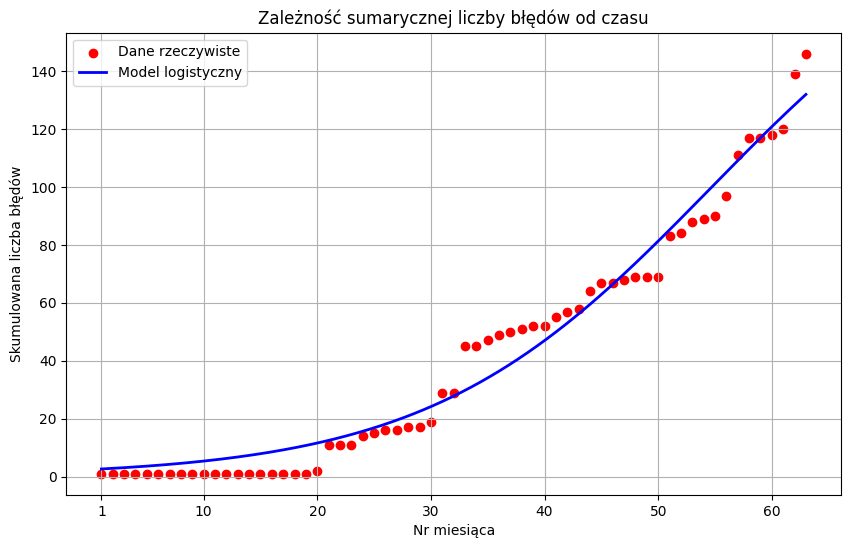

In [146]:
t_smooth_train = np.linspace(min(t_train), max(t_train), 300)
plt.figure(figsize=(10, 6))
plt.scatter(t_train, Sb_t_train, color='red', label='Dane rzeczywiste')
plt.plot(t_smooth_train, logistic_function(t_smooth_train, *popt), color='blue', linewidth=2, label='Model logistyczny')
xticks = np.arange(0, 70, 10)
xticks = np.append(xticks, 1)
xticks = xticks[xticks != 0]
plt.xticks(xticks)
plt.title('Zależność sumarycznej liczby błędów od czasu')
plt.xlabel('Nr miesiąca')
plt.ylabel('Skumulowana liczba błędów')
plt.legend()
plt.grid(True)
plt.show()

# Model dla podzielonych danych oraz danych zagregowanych

In [97]:
# train and test splits lub mozemy przyjac po prostu ze znajdujemy sie (mamy dane do 63. miesiąca a pozostałych nie mamy) w 63. miesiacu
os_errors_Q_train_df = os_errors_df_quarterly[os_errors_df_quarterly["Nr kwartału"] <= 21] # ~68% : ~32% (zazwyczaj sie bierze 70% - 30% lub 80% do 20 % aczkolwiek tutaj te proporcje są zbliżone właśnie do 70% i 30% test setu)
os_errors_Q_test_df = os_errors_df_quarterly[os_errors_df_quarterly["Nr kwartału"] > 21]
os_errors_Q_test_plot_df = os_errors_df_quarterly[os_errors_df_quarterly["Nr kwartału"] >= 21] # po to zeby na wykresie nie było przerwy

In [98]:
t_Q_train, t_Q_test = os_errors_Q_train_df["Nr kwartału"].values, os_errors_Q_test_df["Nr kwartału"].values
Sb_t_Q_train, Sb_t_Q_test = os_errors_Q_train_df["Sb_t_Q"].values, os_errors_Q_test_df["Sb_t_Q"].values
t_Q_test_plot, Sb_t_Q_test_plot = os_errors_Q_test_plot_df["Nr kwartału"].values, os_errors_Q_test_plot_df["Sb_t_Q"].values

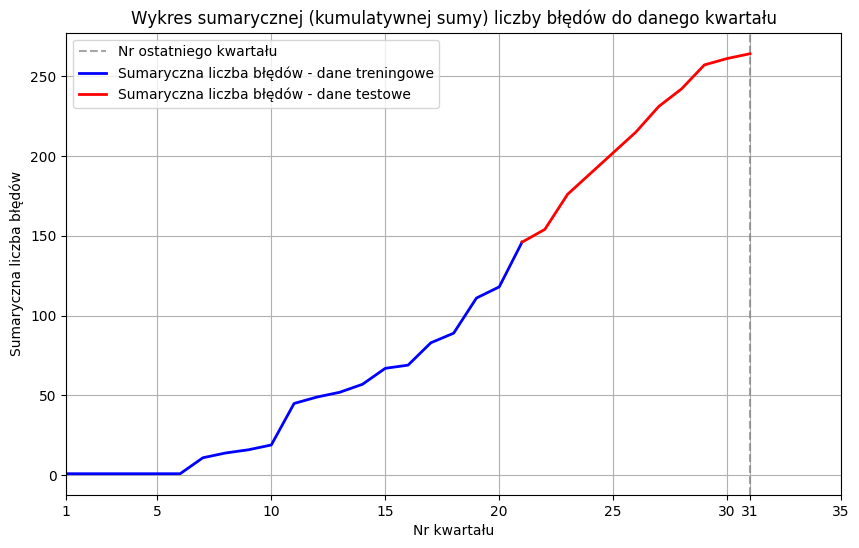

In [99]:
plt.figure(figsize=(10, 6))
plt.title("Wykres sumarycznej (kumulatywnej sumy) liczby błędów do danego kwartału")
plt.xlabel("Nr kwartału")
plt.ylabel("Sumaryczna liczba błędów")
plt.xlim(1, 32)
xticks = plt.xticks()[0].tolist()
xticks = [x for x in xticks if x >= 1]
if 31 not in xticks:
    xticks.append(31)
if 1 not in xticks:
    xticks.append(1)
plt.xticks(xticks)
plt.axvline(31, linestyle='--', color='gray', alpha=0.7, label='Nr ostatniego kwartału')
plt.plot(t_Q_train, Sb_t_Q_train, color='blue', linewidth=2, label='Sumaryczna liczba błędów - dane treningowe')
plt.plot(t_Q_test_plot, Sb_t_Q_test_plot, color='red', linewidth=2, label='Sumaryczna liczba błędów - dane testowe')
plt.grid(True)
plt.legend()
plt.show()

In [100]:
p0 = [max(Sb_t_Q_train), 1.0, np.median(t_Q_train)]

popt, pcov = curve_fit(logistic_function, t_Q_train, Sb_t_Q_train, p0)
K_opt, a_opt, t0_opt = popt

print(f"Parametry modelu:\nK (nasycenie) = {K_opt}\na (tempo wzrostu) = {a_opt}\nt0 (punkt przegięcia) = {t0_opt}")

Parametry modelu:
K (nasycenie) = 219.04731406772996
a (tempo wzrostu) = 0.23178346104750253
t0 (punkt przegięcia) = 18.86107112726697


In [101]:
print(f"R^2: {calculate_r_squared(logistic_function(t_Q_train, *popt), Sb_t_Q_train)}")

R^2: 0.9755284113074679


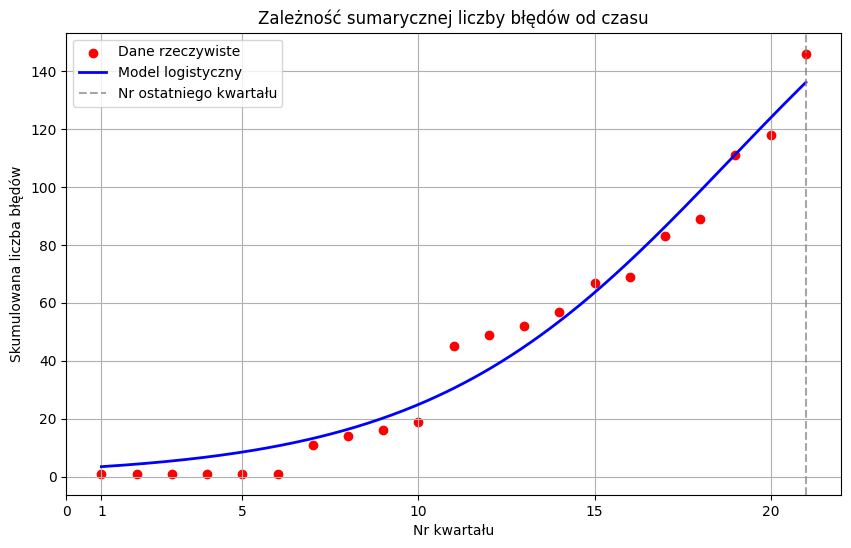

In [114]:
t_smooth_Q_train = np.linspace(min(t_Q_train), max(t_Q_train), 300)
plt.figure(figsize=(10, 6))
plt.scatter(t_Q_train, Sb_t_Q_train, color='red', label='Dane rzeczywiste')
plt.plot(t_smooth_Q_train, logistic_function(t_smooth_Q_train, *popt), color='blue', linewidth=2, label='Model logistyczny')
plt.axvline(21, linestyle='--', color='gray', alpha=0.7, label='Nr ostatniego kwartału')
plt.xlim(1, 22)
xticks = np.arange(0, 25, 5)
xticks = np.append(xticks, 1)
plt.xticks(xticks)
plt.title('Zależność sumarycznej liczby błędów od czasu')
plt.xlabel('Nr kwartału')
plt.ylabel('Skumulowana liczba błędów')
plt.legend()
plt.grid(True)
plt.show()

# Podsumowanie
W celu zbadania zależności oraz dopasowania sumarycznej liczby błędów do krzywej funkcji logistycznej, zdecydowano także na zbudowanie modeli dla:


1.   Kwartałów
2.   Danych do 63. miesiąca (podział danych na dane treningowe i testowe / założenie, że jesteśmy w 63. miesiącu i nie mamy informacji o kolejnych)
3. Kwartałów z podziałem danych do 21. kwartału (podział danych na dane treningowe i testowe / założenie, że jesteśmy w 21. kwartale i nie mamy informacji o kolejnych)

**Model z 1.:**
Wartości nasycenia (max liczba błędów) oraz punkt przegięcia minimalnie zmalały natomiast tempo wzrostu lekko wzrosło. Model również bardzo dobrze opisuje proces wykrywania błędów w badanym systemie operacyjnym, minimalnie gorzej niż model z miesiącami oraz bez podziału zbioru danych ze względu na minimalnie mniejszą wartość nasycenia, świadczy o tym współczynnik determinacji R^2 równy ok. ~99,6%, co odpowiada pierwszemu zbudowanemu modelowi. Krzywa też praktycznie idealnie pokrywa się z danymi.

**Model z 2.:**
Wartości nasycenia oraz punkt przegięcia drastycznie zmalały. Tempo wzorstu wzrosło. Można było się tego spodziewać, gdyż zbiór treningowy pomniejszył się ze względu na rozdzielenie danych na dane treningowe i testowe. Mimo tego, model nadal bardzo dobrze opisuje dane, aczkolwiek to dopasowanie jest gorsze od poprzednich 2 modeli, gdyż wynosi ~97%. Warto jednak zaznaczyć, że nie jest to dobry model, gdyż maksymalna liczba błędów SO (nasycenie) jest bardzo zaniżone porównując je z pełnymi danymi i przyjęcie tego modelu / zdecydowanie się na nie czekanie do co najmniej 93. miesiąca skutkowałoby błędnym założeniem maksymalnej liczby błędów, które wystąpiłyby w systemie, co mogłoby mieć tragiczne skutki w procesie wdrażania i późniejszej eksploatacji systemu.


**Model z 3.:**
Tempo wzrostu wzrosło minimalnie oraz punkt przegięcia zmalał w porównaniu z poprzednim modelem zagregowanym do kwartałów. Można natomiast zauważyć ciekawy wynik, mianowicie - nasycenie wzrosło w porównaniu z modelem, w którym też zastosowano podział danych. Jak widać, agregacja danych do kwartałów zamiast pozostawienia miesięcy pomogło trochę polepszyć ten model. On jednak również nie jest najlepszy, gdyż maksymalna liczba błędów SO (nasycenie) jest bardzo zaniżone porównując je z pełnymi danymi i przyjęcie tego modelu / zdecydowanie się na nie czekanie do co najmniej 93. miesiąca skutkowałoby błędnym założeniem maksymalnej liczby błędów, które wystąpiłyby w systemie, co mogłoby mieć tragiczne skutki w procesie wdrażania i późniejszej eksploatacji systemu. Dopasowanie jest gorsze od poprzednich 2 modeli z dopasowaniem na poziomie ~99,6%, gdyż wynosi ~97%.

**Dodatkowe wnioski:**
Analiza wykazała, że modele wymagają jak największej liczności danych, aby wiarygodnie estymować poziom nasycenia. Zbyt wczesne ucięcie danych sugeruje mniejszą liczbę błędów SO, co może w praktyce mieć poważne skutki dla użytkowanego systemu. Agregacja danych do kwartałów pozwoliła na zwiększenie, w przypadku modelu z podziałem danych, jakości estymacji nasycenia niż w analogicznym modelu miesięcznym. Jednakże trzeba zauważyć, że największą wartość ma model zbudowany dla całych danych w ujęciu miesięcznym.
